In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


There are two methods we used for vectorizing the articles: Word2Vec/Doc2Vec and BERT. You can comment out either blocks while running to see the different results. We added our truth source with values 1.0 in different batches to give our training data a reference point.

In [ ]:
# Using Word2Vec and Doc2Vec for encodings:

import json
import numpy as np
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset from result.json
with open('results.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

with open('source.txt', 'r', encoding='utf-8') as source_file:
    source_text = source_file.read()

# Group by estimated paragraphs of IPCC (around 5 sentences)
sentences = source_text.split('.')
chunks = [sentences[i:i + 5] for i in range(0, len(sentences), 5)]
flattened_text = [''.join(chunk).replace('\n', '') for chunk in chunks]

# Extract content from the json object
documents = [article['text'] for article in data['Results']]
y = np.array([article['truth'] for article in data['Results']] + [1.0] * len(flattened_text))
documents = documents + flattened_text

# Word Embeddings (Word2Vec)
# Tokenize the documents
tokenized_documents = [doc.split() for doc in documents]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_documents, vector_size=100, window=5, min_count=1, workers=4)

# Sentence Embeddings (Doc2Vec)
# Tag the documents for Doc2Vec training
tagged_documents = [TaggedDocument(words=doc.split(), tags=[str(idx)]) for idx, doc in enumerate(documents)]

# Train Doc2Vec model
doc2vec_model = Doc2Vec(tagged_documents, vector_size=100, window=5, min_count=1, workers=4, epochs=10)

# TF-IDF Vectorizer
# vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
# tfidf_matrix = vectorizer.fit_transform(documents)
# dense_tfidf_array = tfidf_matrix.toarray()

vectors = []

# Now you can obtain the word embeddings / sentence embeddings for each document
for idx, doc in enumerate(documents):
    # Word Embeddings
    word_embeddings = [word2vec_model.wv[word] for word in doc.split() if word in word2vec_model.wv]

    # Sentence Embeddings
    doc2vec_embedding = doc2vec_model.dv[str(idx)]
    vectors.append(doc2vec_embedding)

    # TF-IDF Vectors
    # tfidf_vector = dense_tfidf_array[idx]

In [ ]:
# Using BERT for encodings

from transformers import BertTokenizer, TFAutoModel
import numpy as np
import json


# Load the dataset from result.json
with open('results.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

with open('source.txt', 'r', encoding='utf-8') as source_file:
    source_text = source_file.read()

# Group by estimated paragraphs of IPCC (around 5 sentences)
sentences = source_text.split('.')
chunks = [sentences[i:i + 5] for i in range(0, len(sentences), 5)]
flattened_text = [''.join(chunk).replace('\n', '') for chunk in chunks]

# Extract content from the json object
documents = [article['text'] for article in data['Results']]
y = np.array([article['truth'] for article in data['Results']] + [1.0] * len(flattened_text))
documents = documents + flattened_text

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFAutoModel.from_pretrained("bert-base-uncased")

def vectorize_text(paragraphs):
    # Tokenize and pad sequences
    tokenized_inputs = tokenizer(paragraphs, padding=True, truncation=True, return_tensors="tf", max_length=128)

    # Get BERT embeddings
    outputs = model(**tokenized_inputs)
    embeddings = outputs.last_hidden_state

    # Use the mean pooling to get a fixed-size representation for each paragraph
    avg_pooled = tf.reduce_mean(embeddings, axis=1)

    return avg_pooled

vectors = vectorize_text(documents)
print(np.array(vectors).shape)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

(458, 768)


In [ ]:
# We tried a SVM (Support Vector Machine) driven model which takes the
# vectorized inputs and their associated classifications (rounded to -1 or 1)
# then trains the model on these classifications with a basic hinge loss to
# allow room for some inconsistency.
# This didn't end up working since SVM only supports outputting classification
# so our loss function was not working as expected. We decided to switch to a
# neural net with a tanh activation to scale between -1 and 1 with a basic mse
# loss. We have 50 epochs since we want to mimimize the loss as much as possible
# to counteract the skew in our training data towards truthful data.

import numpy as np
from sklearn.model_selection import train_test_split

# Vectorized (Doc2Vec / BERT) representations of the articles
X = np.array(vectors)

# Split data into train and test with  f80 20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the SVM model with two layers the first being a basic input layer and
# the next being a basic keras provided kernel to account for nonlinear
# classification model.
svm_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

# Basic hinge loss to allow for some incorrect classifications on training data
# for the sake of an overall more accurate svm_model
def ms_loss(y_true, y_pred):
    return (y_true - y_pred)**2

# We use adam / extended SGD for our optimization because of the high
# dimensionality of our feature vectors and their variability with the kernel.
svm_model.compile(optimizer='adam', loss=ms_loss, metrics=['accuracy'])

svm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

def predict_truthfulness(vectors):
    return svm_model.predict(vectors)

Epoch 1/50
12/12 [==============================] - 1s 20ms/step - loss: 0.8424 - accuracy: 0.1503 - val_loss: 0.2170 - val_accuracy: 0.5870
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1440 - accuracy: 0.7486 - val_loss: 0.1641 - val_accuracy: 0.7174
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1196 - accuracy: 0.7787 - val_loss: 0.1621 - val_accuracy: 0.7174
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1163 - accuracy: 0.7814 - val_loss: 0.1581 - val_accuracy: 0.7174
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1118 - accuracy: 0.7814 - val_loss: 0.1497 - val_accuracy: 0.7174
Epoch 6/50
12/12 [==============================] - 0s 6ms/step - loss: 0.1052 - accuracy: 0.7787 - val_loss: 0.1362 - val_accuracy: 0.7174
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0968 - accuracy: 0.7760 - val_loss: 0.1187 - val_accuracy: 0.7174
Epoch 8/50
12/12 [=

In [ ]:
# Function to load and prepare data
def load_and_prepare_data():
    with open('results.json', 'r', encoding='utf-8') as file:
        data = json.load(file)
    documents = [article['text'] for article in data['Results']]
    titles = [article['title'] for article in data['Results']]
    vectors = vectorize_text(documents)
    return titles, vectors

# Function to display results
def display_results():
    titles, vectors = load_and_prepare_data()
    predictions = predict_truthfulness(vectors)
    for title, score in zip(titles, predictions):
        print(f"Title: {title}, Truthfulness Score: {score[0]:.2f}")

# Call the function to
display_results()

4/4 [==============================] - 0s 4ms/step
Title: July heatwaves ‘virtually impossible’ without climate change, Truthfulness Score: 0.74
Title: The EU wants to crack down on rogue efforts to alter the atmosphere, Truthfulness Score: 0.71
Title: Can banks push Bitcoin to clean up its act?, Truthfulness Score: 0.57
Title: Heat Waves Aren’t Just Getting Hotter—They’re Stickier Too, Truthfulness Score: 0.69
Title: Google hands over its tool for estimating flight emissions to an independent advisory group, Truthfulness Score: 0.62
Title: The Arctic Is a Freezer That’s Losing Power, Truthfulness Score: 0.74
Title: Fukushima’s Radioactive Water Is Going to Be Pumped Into the Ocean—and That’s Fine, Truthfulness Score: 0.87
Title: Inside the First Youth-Led Climate Lawsuit to Go to Trial, Truthfulness Score: 0.58
Title: Amazon is reportedly making employees relocate for return-to-office, Truthfulness Score: 0.62
Title: This Hurricane Season Depends on a Showdown in the Atlantic, Truthfu

3/3 [==============================] - 0s 2ms/step


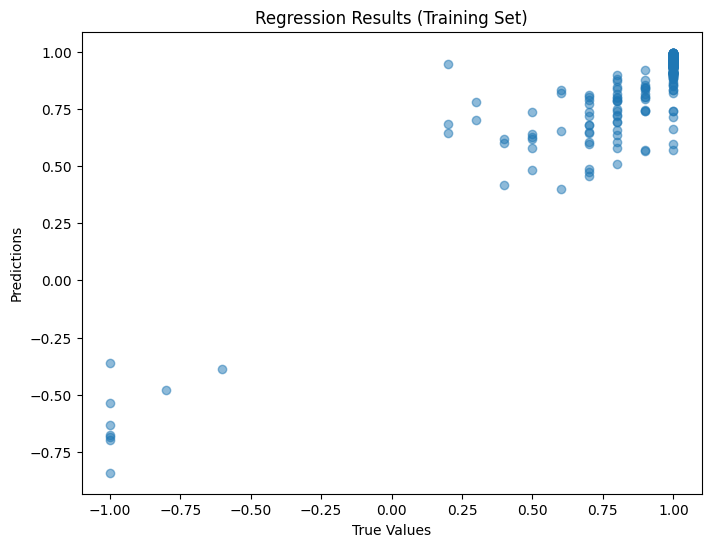

Mean Squared Error: 0.01


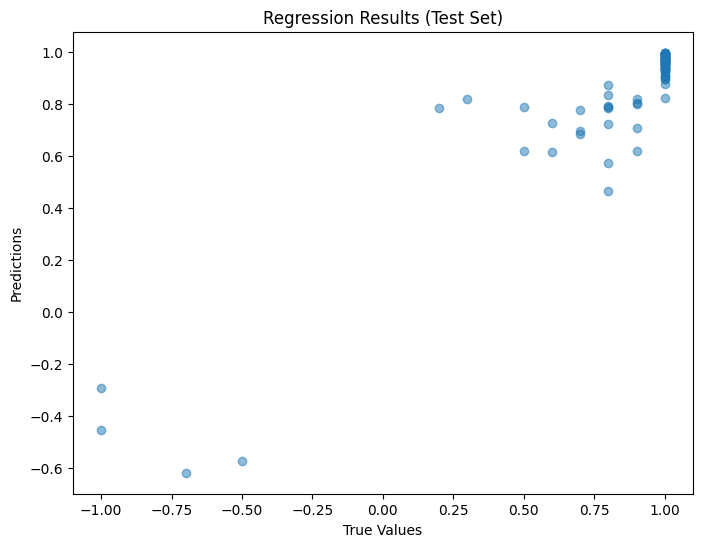

Mean Squared Error: 0.02


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function to plot regression results
def plot_regression_results(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.title(title)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.show()

    mse = mean_squared_error(y_true, y_pred)
    print("Mean Squared Error: {:.2f}".format(mse))

# Predict using your model
y_pred_train = predict_truthfulness(X_train).flatten()
y_pred_test = predict_truthfulness(X_test).flatten()

# Plot regression results for training set
plot_regression_results(y_train, y_pred_train, "Regression Results (Training Set)")

# Plot regression results for test set
plot_regression_results(y_test, y_pred_test, "Regression Results (Test Set)")


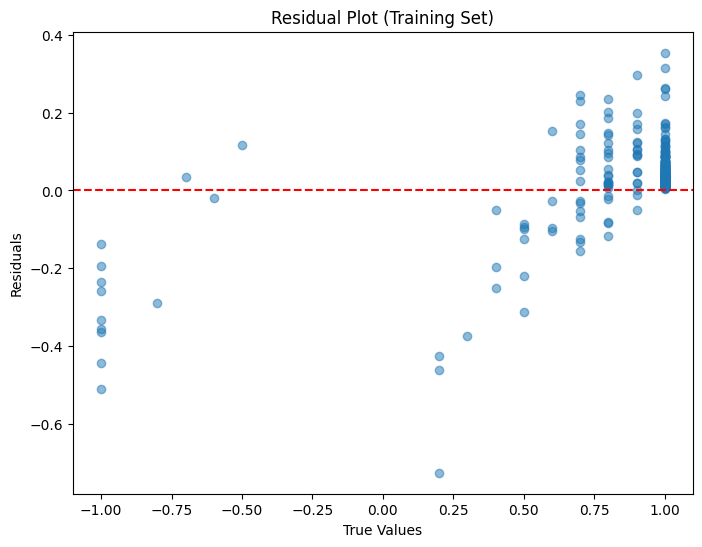

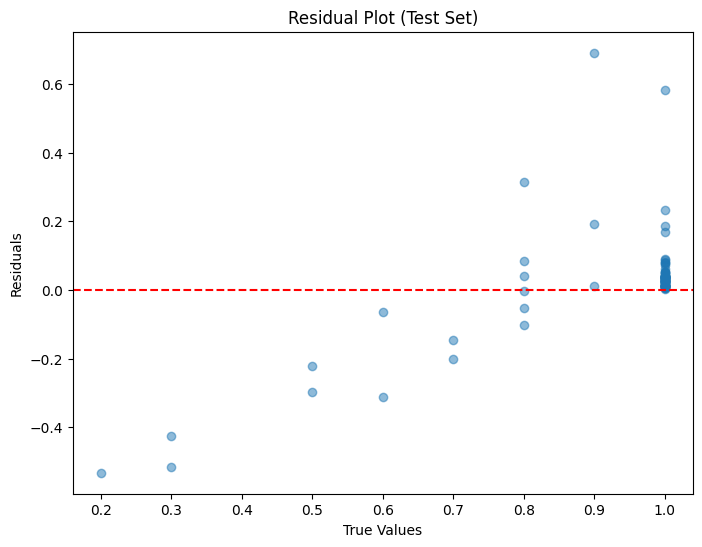

In [ ]:
# Function to plot residual plot
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred

    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, residuals, alpha=0.5)
    plt.title(title)
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
    plt.show()

# Plot residual plot for training set
plot_residuals(y_train, y_pred_train, "Residual Plot (Training Set)")

# Plot residual plot for test set
plot_residuals(y_test, y_pred_test, "Residual Plot (Test Set)")
